#Library and functions

In [ ]:
#--- Reproductibility ---
%env PYTHONHASHSEED=0
from numpy.random import seed
seed(42)
from tensorflow import keras
keras.utils.set_random_seed(42)
import tensorflow as tf
tf.config.experimental.enable_op_determinism()

#---

import numpy as np
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from collections import Counter
import PIL
import glob
from tqdm import tqdm
import networkx as nx

#Graphics
from scipy.stats import gaussian_kde
from scipy.stats import norm
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#NN
from tensorflow import keras
from tensorflow.keras import layers, callbacks
#import tensorflow as tf

#sklearn modules: evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, root_mean_squared_error

#Recurrence plots
from pyts.image import RecurrencePlot
from pyts.datasets import load_gunpoint
from mpl_toolkits.axes_grid1 import ImageGrid

env: PYTHONHASHSEED=0


2024-10-04 15:37:26.908497: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 15:37:27.519162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
def parameter_stratification(value):
  '''
  Assumes the parameters of the logistic map will be in the 3 to 4 range.
  Categories:
  1 - Oscillations between two values
  2 - Oscillations between four values
  3 - Oscillations between nth values, where n is even and >4
  4 - Onset of chaos
  5 - Appearance of stability islands
  '''

  #Periods
  if (value < 3.44949):
    return 1
  if ( (value >= 3.44949) and (value < 3.54409) ):
    return 2
  if ( (value >= 3.54409) and (value < 3.56995) ):
    return 3
  if ( (value >= 3.56995) and (value < 3.82843) ):
    return 4
  if ( (value >= 3.82843) ):
    return 5

# Neural net training: regression

##Architecture

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.AveragePooling2D(2),
  keras.layers.Dropout(0.2),
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.AveragePooling2D(2),
  keras.layers.Dropout(0.2),
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.Conv2D(3, 3, activation='relu'),
  keras.layers.Flatten(),
  keras.layers.Dense(units=1024, activation='relu'),
  keras.layers.Dense(units=512, activation='relu'),
  keras.layers.Dense(units=256, activation='relu'),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer="adam")

2024-10-04 15:37:42.628331: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 15:37:42.662506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 15:37:42.662765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Training

In [ ]:
#Read all pngs from the train set
data_path = '/your/path/'
pngs = glob.glob(data_path + 'IC=0.*/sample*png')

ims = {}
for png in pngs:
  ims[png]=np.array(PIL.Image.open(png).convert('L'))

In [ ]:
#Questions = images
#Solutions = main parameter of the logistic map used to generated that image

questions = np.array([each for each in ims.values()]).astype(np.float32)
solutions = np.array([float(each.split('_')[-1].split('.')[0])/(1e16) for each in ims]).astype(np.float32)

In [ ]:
N_size = 100

#Train/test split (gnuplot data):
X_train, X_test, y_train, y_test = train_test_split(questions, solutions, test_size=0.3, random_state=42)

X_train = X_train.reshape(-1, N_size, N_size, 1)
X_test = X_test.reshape(-1, N_size, N_size, 1)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Epoch 1/300


I0000 00:00:1728059940.342165   53056 service.cc:145] XLA service 0x564bef618270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728059940.342190   53056 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-10-04 13:39:00.388915: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 13:39:00.628528: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 11/281 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 4.9007

I0000 00:00:1728059944.288773   53056 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.6305 - val_loss: 6.2376
Epoch 2/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0681 - val_loss: 3.1527
Epoch 3/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0504 - val_loss: 1.3454
Epoch 4/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0268 - val_loss: 0.2738
Epoch 5/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0180 - val_loss: 0.1866
Epoch 6/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0099 - val_loss: 0.0770
Epoch 7/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0070 - val_loss: 0.0716
Epoch 8/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0063 - val_loss: 0.0687
Epoch 9/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0069 - val_loss: 0.0379
Epoch 10/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0045 - val_loss: 0.0372
Epoch 11/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0045 - val_loss: 0.0229
Epoch 12/300
281/281 ━━━━━━━━━━━━━━━━━━━━

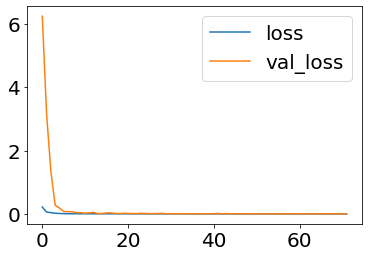

In [ ]:
#Complete region
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Epoch 1/300


I0000 00:00:1728067069.652837   62808 service.cc:145] XLA service 0x55e0d9b43760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728067069.652862   62808 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-10-04 15:37:49.699522: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 15:37:49.947174: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 12/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 5.3374

I0000 00:00:1728067073.569775   62808 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.6992 - val_loss: 7.7864
Epoch 2/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0693 - val_loss: 5.1377
Epoch 3/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0361 - val_loss: 3.3369
Epoch 4/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0223 - val_loss: 1.5991
Epoch 5/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0164 - val_loss: 0.9262
Epoch 6/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0120 - val_loss: 0.2899
Epoch 7/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0120 - val_loss: 0.0824
Epoch 8/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0059 - val_loss: 0.0349
Epoch 9/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0053 - val_loss: 0.0589
Epoch 10/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0053 - val_loss: 0.0662
Epoch 11/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0047 - val_loss: 0.0382
Epoch 12/300
281/281 ━━━━━━━━━━━━━━━━━━━━

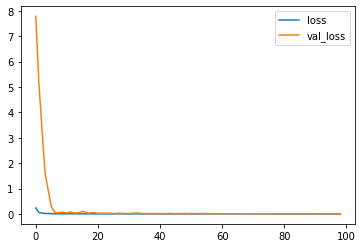

In [ ]:
#Chaotic region
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Epoch 1/300


I0000 00:00:1727215296.095055  104124 service.cc:145] XLA service 0x7fc368003bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727215296.095093  104124 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-09-24 19:01:36.190731: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-24 19:01:36.454326: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


12/71 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.2517 

I0000 00:00:1727215298.681146  104124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 3.5254 - val_loss: 0.1320
Epoch 2/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0537 - val_loss: 0.0763
Epoch 3/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0326 - val_loss: 0.0775
Epoch 4/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0311 - val_loss: 0.0560
Epoch 5/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0259 - val_loss: 0.0418
Epoch 6/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0202 - val_loss: 0.0315
Epoch 7/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0180 - val_loss: 0.0186
Epoch 8/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0144 - val_loss: 0.0193
Epoch 9/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0144 - val_loss: 0.0199
Epoch 10/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0143 - val_loss: 0.0205
Epoch 11/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0142 - val_loss: 0.0157
Epoch 12/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

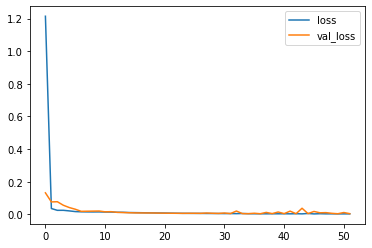

In [ ]:
#--- N=res runs ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

##Testing

In [ ]:
#Read in pngs:
data_path = '/your/path/'
test_pngs = glob.glob(data_path + 'test/sample*png')

test_ims = {}

for png in test_pngs:
  test_ims[png]=np.array(PIL.Image.open(png).convert('L'))


#Prepare test questions and solutions as before:
test_questions = np.array([each for each in test_ims.values()]).astype(np.float32)
test_solutions = np.array([float(each.split('_')[-1].split('.')[0])/(1e16)
                            for each in test_ims]).astype(np.float32)

#Apply model:
test_answers = model.predict(test_questions)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


# Neural net training: classification

##Architecture

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(3, 3),
  keras.layers.Conv2D(3, 3),
  keras.layers.Activation('relu'),
  #keras.layers.MaxPooling2D(2),
  keras.layers.AveragePooling2D(2),
  keras.layers.Dropout(0.2),
  keras.layers.Conv2D(3, 3),
  keras.layers.Conv2D(3, 3),
  keras.layers.Activation('relu'),
  #keras.layers.MaxPooling2D(2),
  keras.layers.AveragePooling2D(2),
  keras.layers.Dropout(0.2),
  keras.layers.Conv2D(3, 3),
  keras.layers.Conv2D(3, 3),
  keras.layers.Activation('relu'),
  #keras.layers.MaxPooling2D(2),
  keras.layers.AveragePooling2D(2),
  keras.layers.Dropout(0.2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=1024, activation='relu'),
  keras.layers.Dense(units=512, activation='relu'),
  keras.layers.Dense(units=256, activation='relu'),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dense(units=6, activation='softmax')
])

model.compile(loss='CategoricalCrossentropy', optimizer="adam", metrics=['accuracy'])

2024-10-04 11:34:31.428363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 11:34:31.463470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-04 11:34:31.463717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Training

In [ ]:
#Read all pngs from the train set
data_path = '/your/path/'
pngs = glob.glob(data_path + 'IC=0.*/sample*png')

ims = {}
for png in pngs:
    ims[png]=np.array(PIL.Image.open(png).convert('L'))

In [ ]:
#Questions = images
#Solutions = a parameter that generated that image

questions = np.array([each for each in ims.values()]).astype(np.float32)
solutions_swp = np.array([float(each.split('_')[-1].split('.')[0])/(1e16)
                            for each in ims]).astype(np.float32)

solutions = []
for n in solutions_swp:
  solutions.append(parameter_stratification(n))

In [ ]:
N_size = 100

#Train/test split (gnuplot data):
X_train, X_test, y_train, y_test = train_test_split(questions, solutions, test_size=0.3, random_state=42)

X_train = X_train.reshape(-1, N_size, N_size, 1)
X_test = X_test.reshape(-1, N_size, N_size, 1)

In [ ]:
# Get one hot encoding
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Epoch 1/300


I0000 00:00:1728049939.484501   31428 service.cc:145] XLA service 0x7f3678005820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728049939.484535   31428 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-10-04 10:52:19.552827: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 10:52:19.850796: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  8/281 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3709 - loss: 1.5120

I0000 00:00:1728049945.128615   31428 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7865 - loss: 0.4703 - val_accuracy: 0.9267 - val_loss: 0.1869
Epoch 2/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9372 - loss: 0.1556 - val_accuracy: 0.9324 - val_loss: 0.1628
Epoch 3/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9427 - loss: 0.1404 - val_accuracy: 0.9542 - val_loss: 0.1173
Epoch 4/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9490 - loss: 0.1304 - val_accuracy: 0.9518 - val_loss: 0.1278
Epoch 5/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9513 - loss: 0.1188 - val_accuracy: 0.9617 - val_loss: 0.1057
Epoch 6/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9550 - loss: 0.1136 - val_accuracy: 0.9611 - val_loss: 0.1044
Epoch 7/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9568 - loss: 0.1086 - val_accuracy: 0.9680 - val_loss: 0.0936
Epoch 8/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9619 - loss: 0.0976 - val_accurac

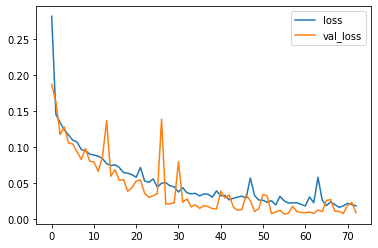

In [ ]:
#Complete region
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Epoch 1/300


I0000 00:00:1728052475.710514   37178 service.cc:145] XLA service 0x7f00600070d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728052475.710545   37178 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-10-04 11:34:35.777291: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 11:34:36.009844: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  9/281 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5233 - loss: 1.2452

I0000 00:00:1728052481.137490   37178 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.7106 - loss: 0.5967 - val_accuracy: 0.8323 - val_loss: 0.3943
Epoch 2/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8810 - loss: 0.2961 - val_accuracy: 0.8578 - val_loss: 0.3368
Epoch 3/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8937 - loss: 0.2653 - val_accuracy: 0.8789 - val_loss: 0.3016
Epoch 4/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9012 - loss: 0.2500 - val_accuracy: 0.8775 - val_loss: 0.3627
Epoch 5/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9001 - loss: 0.2514 - val_accuracy: 0.8948 - val_loss: 0.3195
Epoch 6/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9121 - loss: 0.2274 - val_accuracy: 0.9256 - val_loss: 0.2036
Epoch 7/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9166 - loss: 0.2115 - val_accuracy: 0.9334 - val_loss: 0.1975
Epoch 8/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9199 - loss: 0.2092 - val_accurac

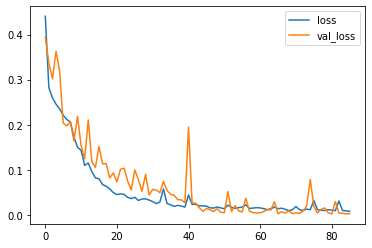

In [ ]:
#Chaotic region
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

##Testing

###Complete region

In [ ]:
data_path = '/your/path/'
test_pngs = glob.glob(data_path + 'test/sample*png')

test_ims = {}

for png in test_pngs:
    test_ims[png]=np.array(PIL.Image.open(png).convert('L'))

test_questions = np.array([each for each in test_ims.values()]).astype(np.float32)
test_solutions_swp = np.array([float(each.split('_')[-1].split('.')[0])/(1e16)
                            for each in test_ims]).astype(np.float32)

test_solutions = []
for n in test_solutions_swp:
  test_solutions.append(parameter_stratification(n))

In [ ]:
#Apply model:
test_answers = model.predict(test_questions)

test_answers_classes = [np.argmax(y, axis=None, out=None) for y in test_answers]
print('Accuracy:', accuracy_score(test_answers_classes, test_solutions))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy: 0.966


In [ ]:
#le = LabelEncoder()
#test_y_swp = le.fit_transform(test_y)

label_binarizer = LabelBinarizer().fit(test_solutions)
test_y_swp = label_binarizer.transform(test_solutions)
pred_y_swp = label_binarizer.transform(test_answers_classes)

In [ ]:
report = classification_report(test_solutions, test_answers_classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
1,1.000000,1.000000,1.000000,439.000
2,1.000000,1.000000,1.000000,93.000
3,1.000000,1.000000,1.000000,22.000
4,0.975309,0.894340,0.933071,265.000
5,0.862069,0.966851,0.911458,181.000
accuracy,0.966000,0.966000,0.966000,0.966
macro avg,0.967476,0.972238,0.968906,1000.000
weighted avg,0.968491,0.966000,0.966238,1000.000


###Chaotic region

In [ ]:
data_path = '/your/path/'
test_pngs = glob.glob(data_path + 'test/sample*png')

test_ims = {}

for png in test_pngs:
    test_ims[png]=np.array(PIL.Image.open(png).convert('L'))

test_questions = np.array([each for each in test_ims.values()]).astype(np.float32)
test_solutions_swp = np.array([float(each.split('_')[-1].split('.')[0])/(1e16)
                            for each in test_ims]).astype(np.float32)

test_solutions = []
for n in test_solutions_swp:
  test_solutions.append(parameter_stratification(n))

In [ ]:
#Apply model:
test_answers = model.predict(test_questions)

test_answers_classes = [np.argmax(y, axis=None, out=None) for y in test_answers]
print('Accuracy:', accuracy_score(test_answers_classes, test_solutions))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy: 0.989


In [ ]:
#le = LabelEncoder()
#test_y_swp = le.fit_transform(test_y)

label_binarizer = LabelBinarizer().fit(test_solutions)
test_y_swp = label_binarizer.transform(test_solutions)
pred_y_swp = label_binarizer.transform(test_answers_classes)

In [ ]:
report = classification_report(test_solutions, test_answers_classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
3,0.944444,1.000000,0.971429,17.000
4,0.990148,0.991776,0.990961,608.000
5,0.989276,0.984000,0.986631,375.000
accuracy,0.989000,0.989000,0.989000,0.989
macro avg,0.974623,0.991925,0.983007,1000.000
weighted avg,0.989044,0.989000,0.989005,1000.000
